# DINEOF

In [1]:
import autoroot
import numpyro
import numpyro.distributions as dist
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import numpy as np
import jax.random as jr
import xarray_einstats
from sklearn.decomposition import PCA
from oi_toolz._src.models.pca import DINEOF
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import pandas as pd
import einx
import cola
from tqdm.auto import trange, tqdm

key = jr.key(123)

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data

In [2]:
ds = xr.tutorial.open_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [3]:
# change units
# ds = ds.sel(time=slice("2013-01-01", "2013-02-01"))
ds["air"] = ds.air - 273.15

In [4]:
sigma = 0.01
rng = np.random.RandomState(123)
ds["air_noisy"] = ds["air"].copy() + sigma ** 2 * rng.normal(*ds["air"].shape[:-1])

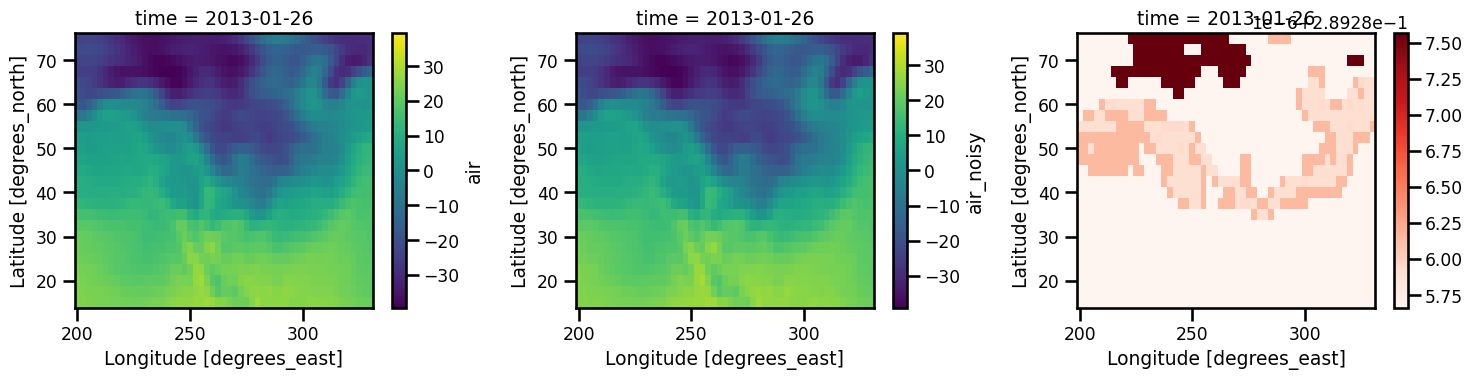

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 100

ds.air.isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
ds.air_noisy.isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
np.abs(ds.air - ds.air_noisy).isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

### Rearrange Data

In [6]:
# tranpose
ds = ds.transpose("time", "lon", "lat")
ds = ds.stack(spatial=["lon", "lat"])

In [7]:
n_space = ds.spatial.shape[0]
n_time = ds.time.shape[0]

In [8]:
ds

<xarray.Dataset>
Dimensions:    (time: 2920, spatial: 1325)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * spatial    (spatial) object MultiIndex
  * lon        (spatial) float32 200.0 200.0 200.0 200.0 ... 330.0 330.0 330.0
  * lat        (spatial) float32 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
Data variables:
    air        (time, spatial) float32 -31.95 -29.35 -23.15 ... 22.04 22.54
    air_noisy  (time, spatial) float32 -31.66 -29.06 -22.86 ... 22.33 22.83
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### PCA

In [114]:
X = ds.air.values.T
n_components = None

clf = PCA(n_components=n_components, random_state=42)
clf.fit(X=X)

X_red = clf.transform(X)
X_recon = clf.inverse_transform(X_red)

In [115]:
X_recon.shape

(1325, 2920)

In [116]:
ds["air_recon"] = (("spatial", "time" ), X_recon)

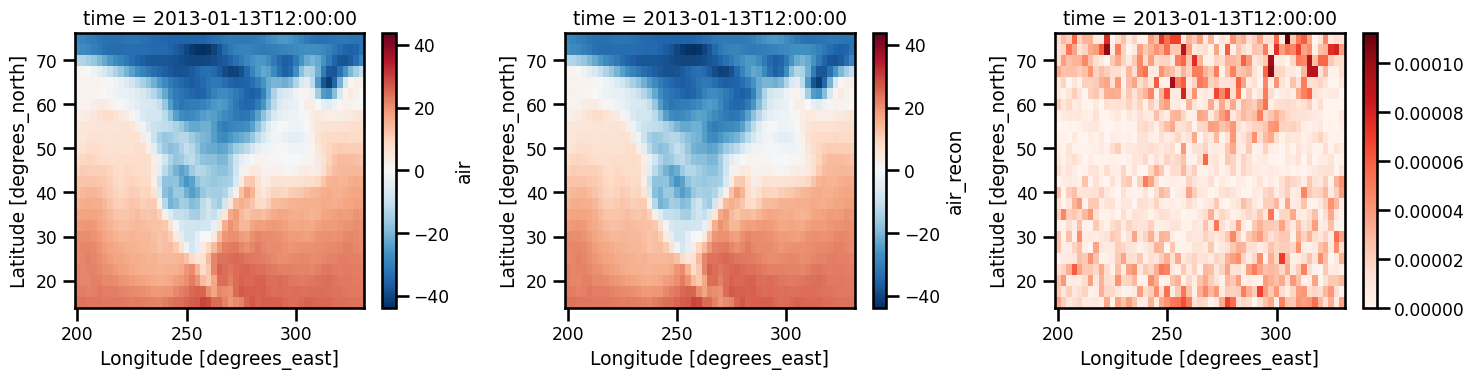

In [118]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 50

ds.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
ds.air_recon.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(ds.air - ds.air_recon).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

## Missing Data

In [125]:
def set_random_fraction_to_nan(data):
    data[np.random.rand(*data.shape) < .9]=np.nan
    return data

In [126]:
ds["air_obs"] = ds["air"].copy()

In [127]:
ds

<xarray.Dataset>
Dimensions:    (time: 2920, spatial: 1325)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * spatial    (spatial) object MultiIndex
  * lon        (spatial) float32 200.0 200.0 200.0 200.0 ... 330.0 330.0 330.0
  * lat        (spatial) float32 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
Data variables:
    air        (time, spatial) float32 -31.95 -29.35 -23.15 ... 22.04 22.54
    air_noisy  (time, spatial) float32 -31.66 -29.06 -22.86 ... 22.33 22.83
    air_recon  (spatial, time) float32 -31.95 -31.05 -30.85 ... 22.04 22.54
    air_obs    (time, spatial) float32 -31.95 -29.35 -23.15 ... 22.04 22.54
    air_new    (spatial, time) float32 -24.61 -29.93 -22.81 ... 22.04 22.54
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [128]:
# Set 80% of data randomly to nan
dims = ['time','spatial']
ds["air_obs"] = xr.apply_ufunc(set_random_fraction_to_nan, ds["air_obs"], input_core_dims=[dims],output_core_dims=[dims], dask='parallelized')

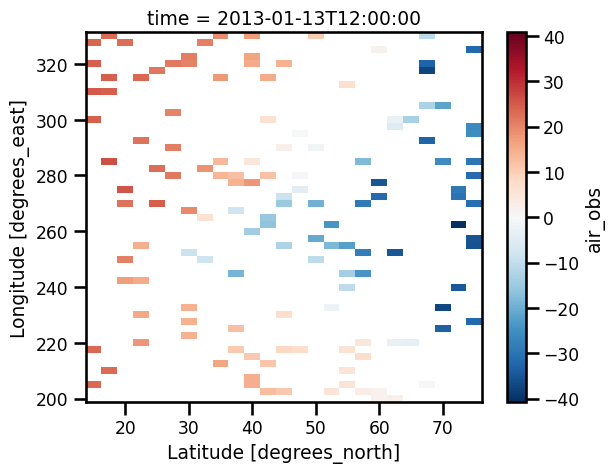

In [129]:
ds.air_obs.unstack().isel(time=itime).plot.pcolormesh()

## Initial Condition

In [130]:
data = ds["air_obs"]

data = data.transpose("spatial", "time")

In [131]:
nan_mask = np.isnan(data)
non_nan_mask = ~nan_mask

# data = data.fillna(value=0.0)
data = data.interpolate_na(dim="time", method="slinear", fill_value="extrapolate")

X = data.values

In [132]:
num_components = 50
num_iters = 1_000
err = 0.0

losses = []

pbar = trange(num_iters, desc='Reconstruction', leave=True)
for i in pbar:

    # extract inputs

    # apply PCA
    clf = PCA(n_components=num_components, random_state=i)
    clf.fit(X=X)

    # calculate reconstruction
    X_red = clf.transform(X)
    X_recon = clf.inverse_transform(X_red)

    # set reconstructed values
    X_recon[non_nan_mask] = X[non_nan_mask]

    err_new = np.sqrt(np.mean(np.power(X[nan_mask] - X_recon[nan_mask], 2))) / X[non_nan_mask].std()

    pbar.set_postfix(error=err_new, rel_error=abs(err_new - err))
    
    losses.append(err_new)

    err = err_new
    X = X_recon

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

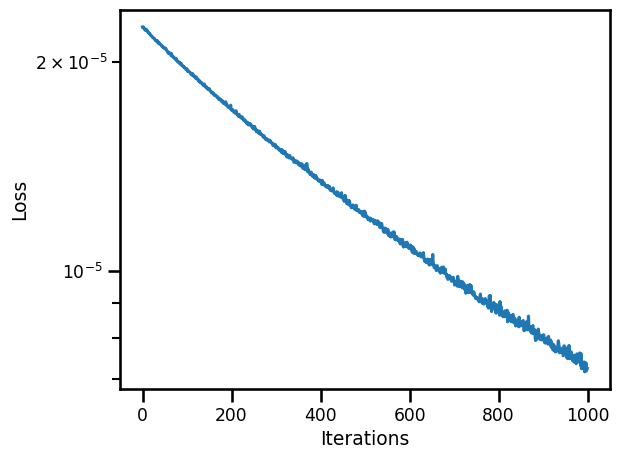

In [95]:
fig, ax = plt.subplots()

ax.plot(losses)

ax.set(xlabel="Iterations", ylabel="Loss", yscale="log")

plt.tight_layout()
plt.show()

In [93]:
ds["air_new"] = (("spatial", "time"), X)

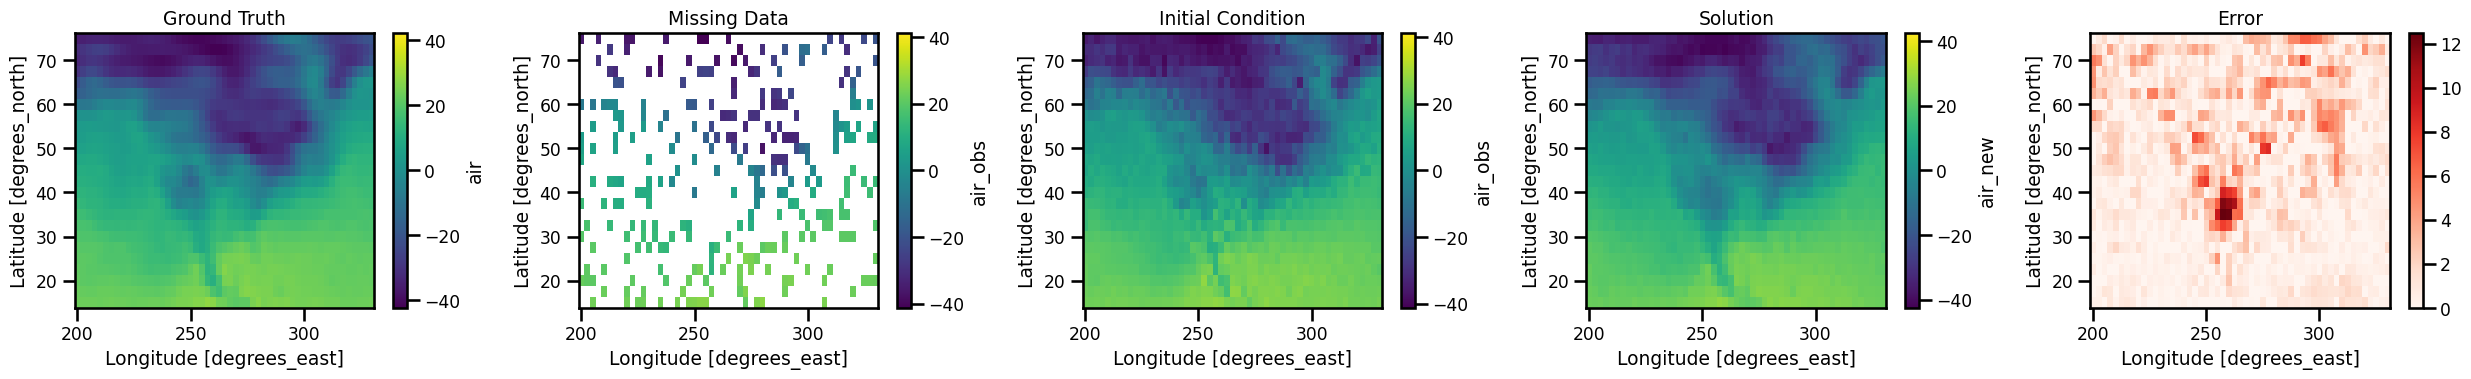

In [96]:
fig, ax = plt.subplots(ncols=5, figsize=(25,4))

itime = 150

ds.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
ds.air_obs.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
data.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2], cmap="viridis")
ds.air_new.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[3], cmap="viridis")
np.abs(ds.air.isel(time=itime) - ds.air_new.isel(time=itime)).unstack().plot.pcolormesh(x="lon",ax=ax[4],cmap="Reds")

ax[0].set(title="Ground Truth")
ax[1].set(title="Missing Data")
ax[2].set(title="Initial Condition")
ax[3].set(title="Solution")
ax[4].set(title="Error")
plt.tight_layout()
plt.show()

## Multi-Components

In [133]:
data = ds["air_obs"]

data = data.transpose("spatial", "time")

In [134]:
nan_mask = np.isnan(data)
non_nan_mask = ~nan_mask

# data = data.fillna(value=0.0)
data = data.interpolate_na(dim="time", method="slinear", fill_value="extrapolate")

X = data.values

In [135]:
num_iters = 1_000
num_components = [1, 5, 10, 20, 30, 40, 50]

In [136]:
X.shape

(1325, 2920)

In [137]:
X = data.values
pbar_components = tqdm(num_components, desc="Components")


err = 0.0
losses = []
X_recons = {}
for n in pbar_components:
    pbar = trange(num_iters, desc='Reconstruction', leave=False)
    for i in pbar:

        # extract inputs

        # apply PCA
        clf = PCA(n_components=n, random_state=i, svd_solver="randomized")
        clf.fit(X=X)

        # calculate reconstruction
        X_red = clf.transform(X)
        X_recon = clf.inverse_transform(X_red)

        # set non reconstructed values
        X_recon[non_nan_mask] = X[non_nan_mask]

        err_new = np.sqrt(np.mean(np.power(X[nan_mask] - X_recon[nan_mask], 2))) / X[non_nan_mask].std()
        
        rel_error = abs(err_new - err)
        pbar.set_postfix(error=err_new, rel_error=rel_error)
        losses.append(err_new)
        if rel_error < 1e-10:
            break

        err = err_new
        X = X_recon
        X_recons[n] = X.copy()
    pbar_components.set_postfix(error=err_new, rel_error=abs(err_new - err))


Components:   0%|          | 0/7 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

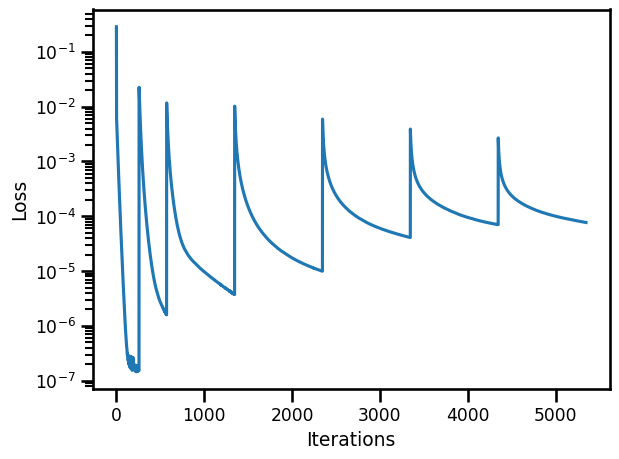

In [138]:
fig, ax = plt.subplots()

ax.plot(losses)

ax.set(xlabel="Iterations", ylabel="Loss", yscale="log")

plt.tight_layout()
plt.show()

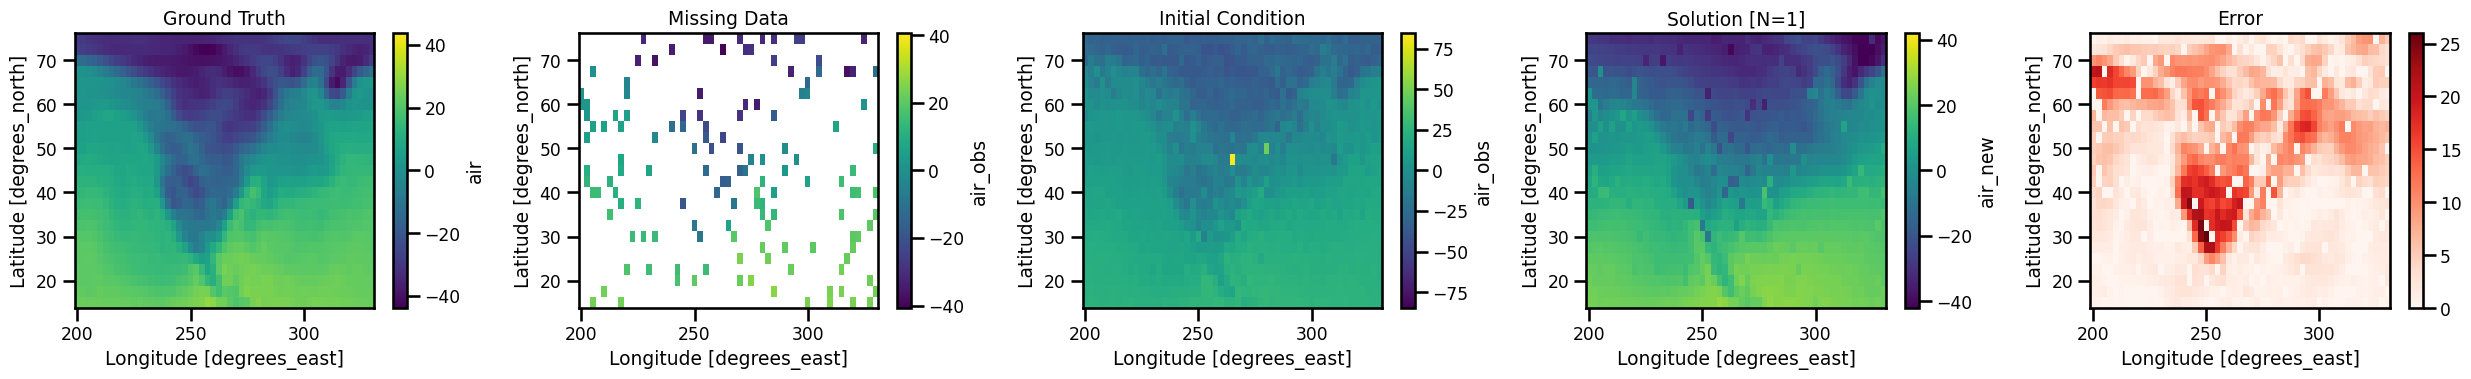

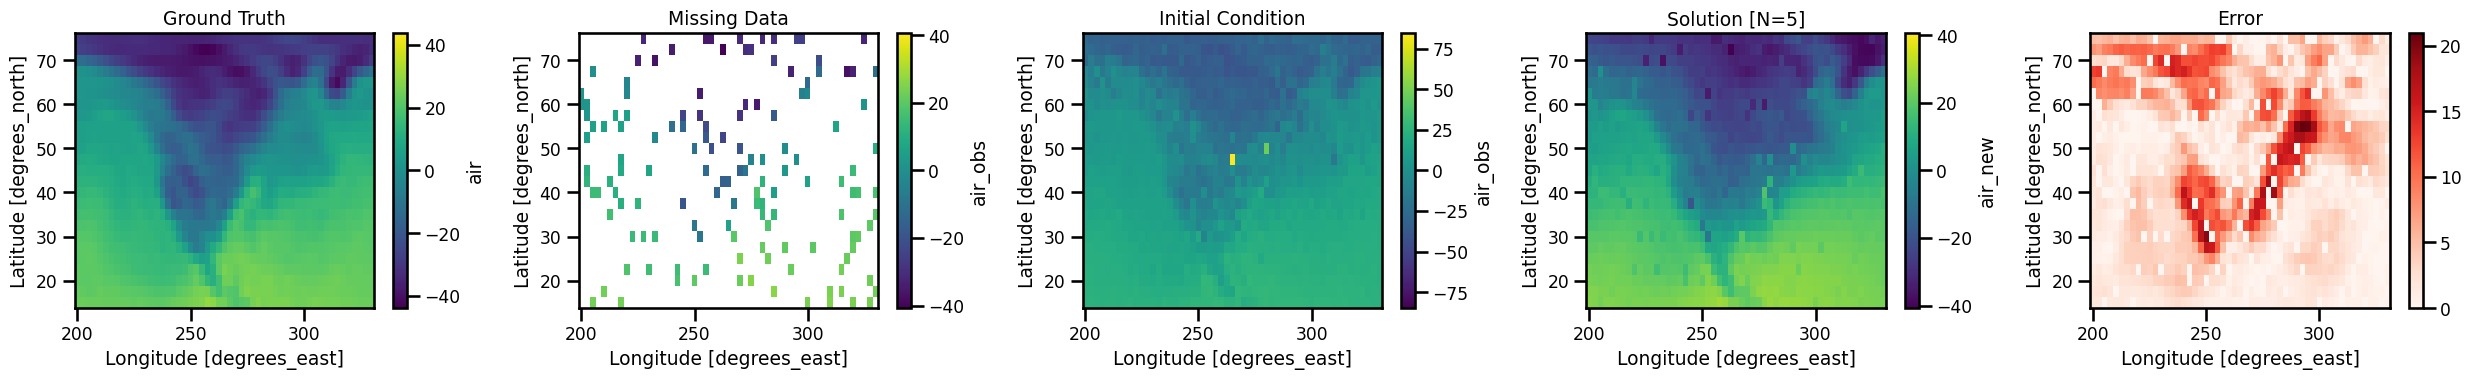

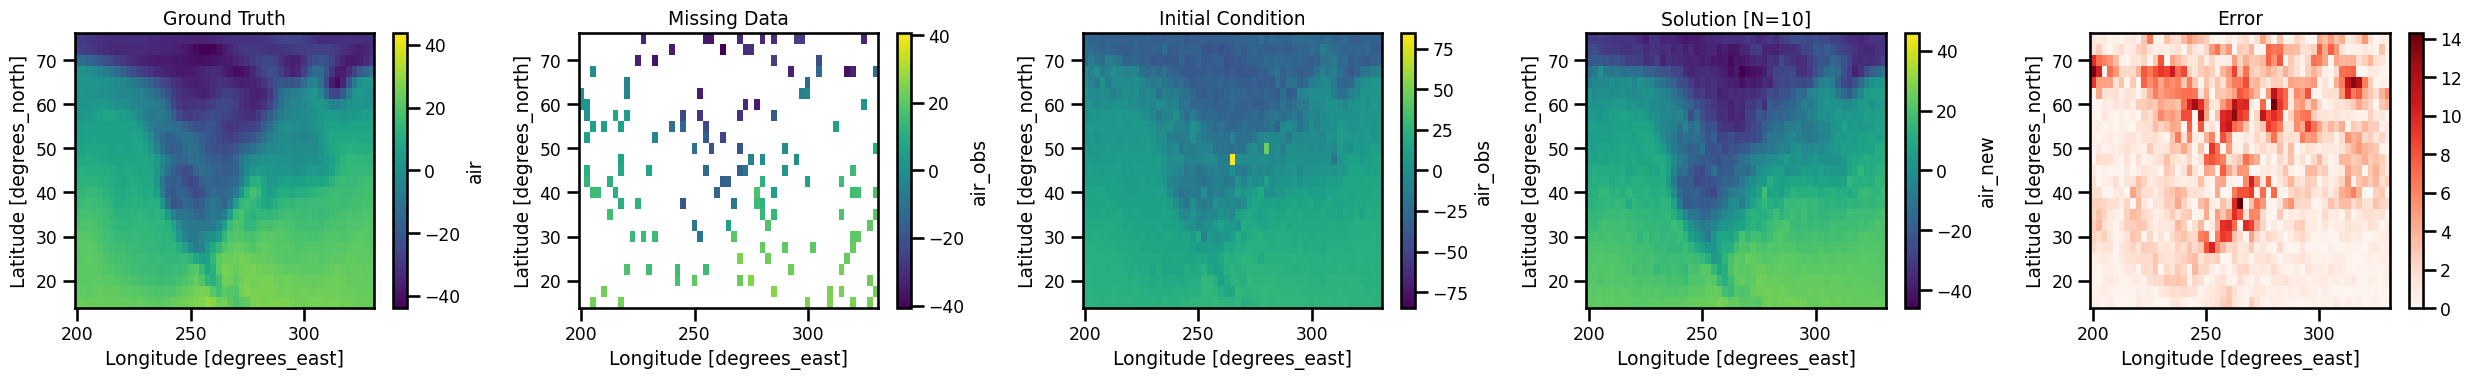

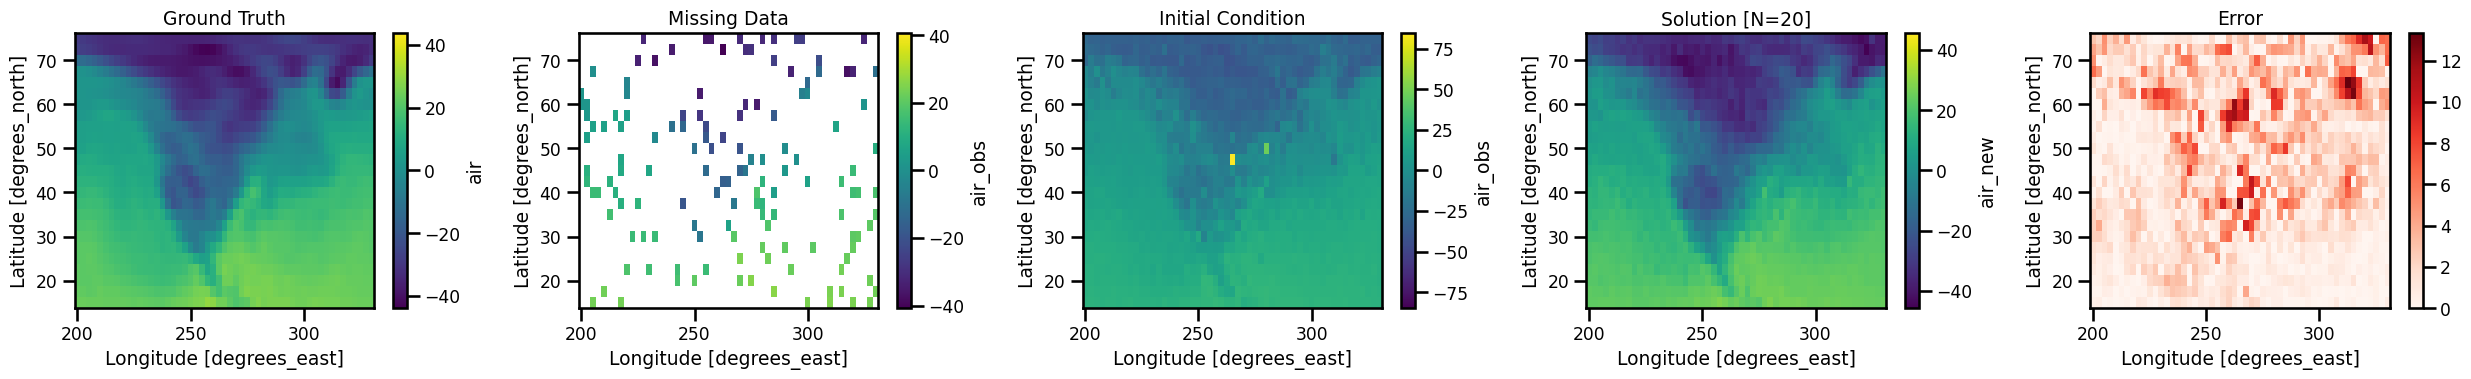

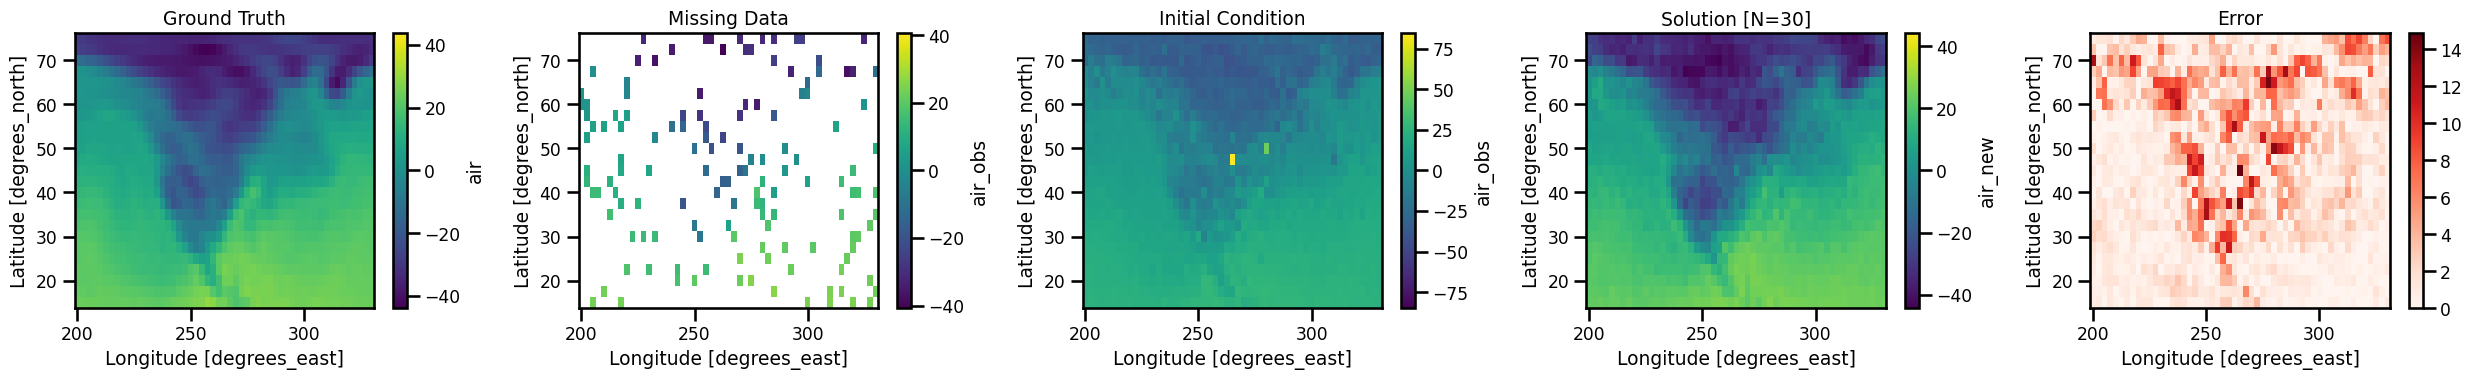

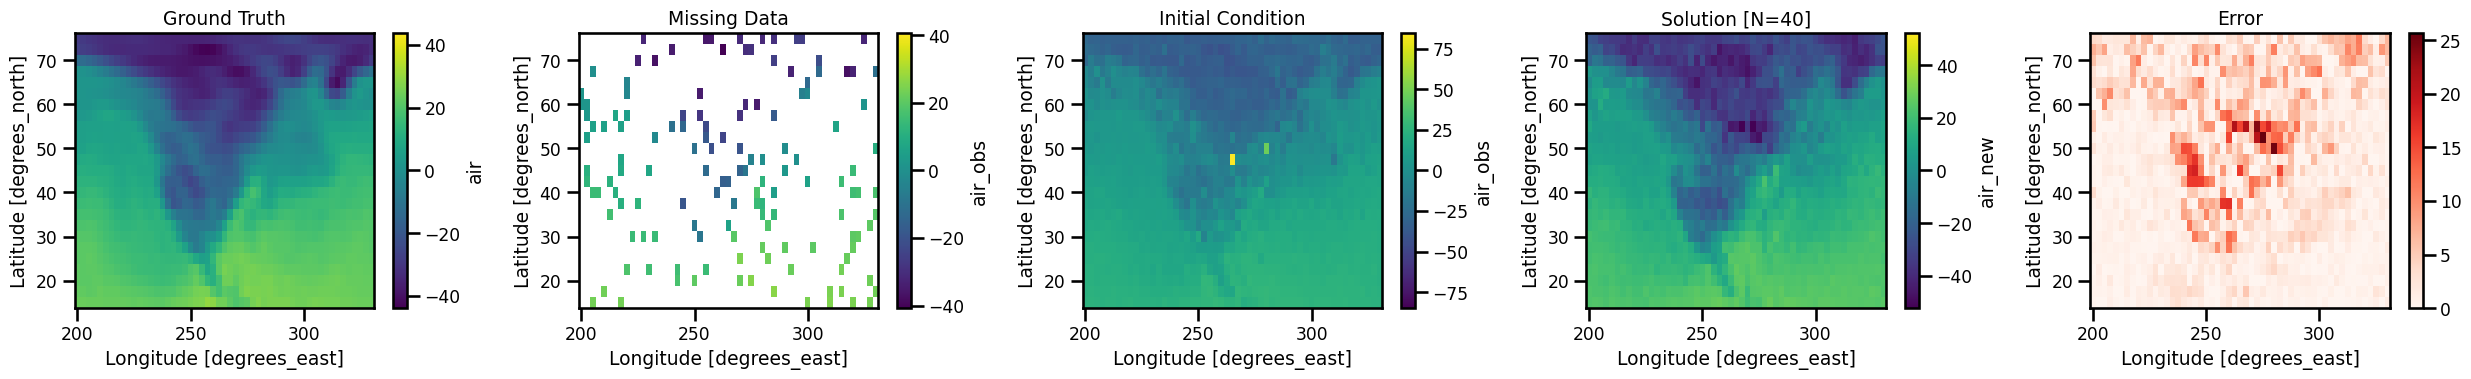

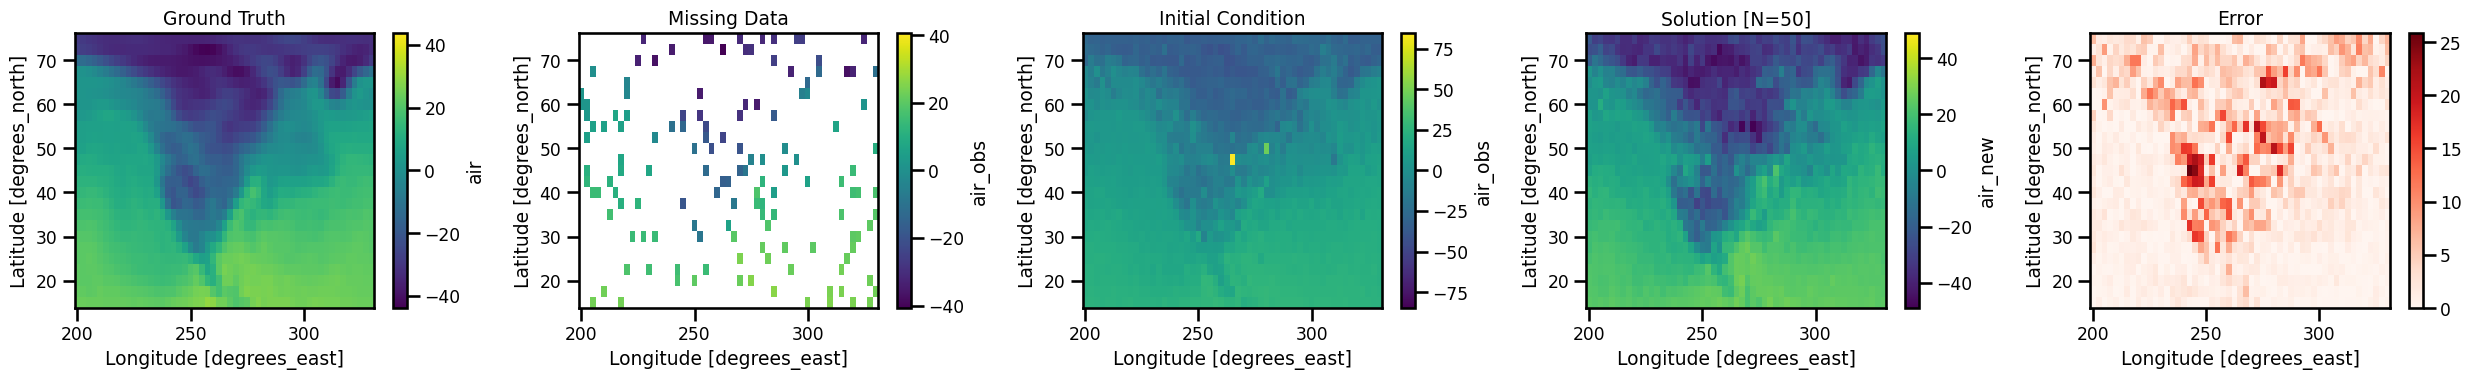

In [139]:

for i in num_components:

    fig, ax = plt.subplots(ncols=5, figsize=(25,4))

    ds["air_new"] = (("spatial", "time",), X_recons[i])

    itime = 50

    ds.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
    ds.air_obs.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
    data.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2], cmap="viridis")
    ds.air_new.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[3], cmap="viridis")
    np.abs(ds.air.isel(time=itime) - ds.air_new.isel(time=itime)).unstack().plot.pcolormesh(x="lon",ax=ax[4],cmap="Reds")

    ax[0].set(title="Ground Truth")
    ax[1].set(title="Missing Data")
    ax[2].set(title=f"Initial Condition")
    ax[3].set(title=f"Solution [N={i}]")
    ax[4].set(title="Error")
    plt.tight_layout()
    plt.show()

In [186]:
data = X

In [187]:
data

array([[ 0.0000000e+00, -7.0252338e-07,  0.0000000e+00, ...,
         0.0000000e+00,  2.3763764e-06,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-4.3705229e-05,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  2.5476020e-06,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  2.3763835e-06,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -1.5606513e-06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.6350427e-06,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [174]:
err

1.098653

In [396]:
clf.fit(X=data.values)

X_red = clf.transform(data.values)
X_recon = clf.inverse_transform(X_red)

In [144]:
ds.air_obs.max()

<xarray.DataArray 'air_obs' ()>
array(42.63998413)

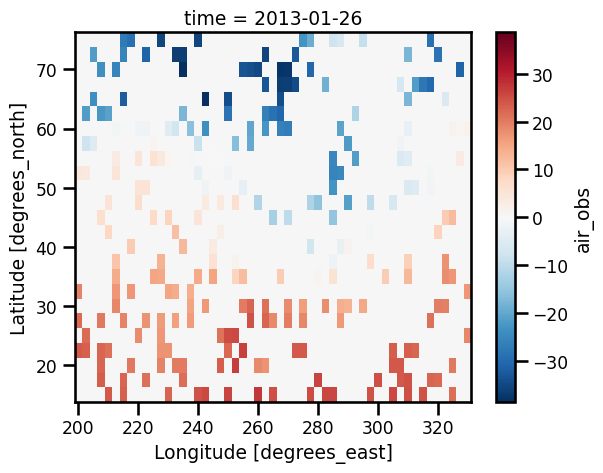

In [145]:
ds.air_obs.isel(time=itime).plot.pcolormesh()

In [ ]:
nan_mask = np.logical_and(np.isnan(ds["air_mask"]), self.mask)

In [ ]:
# Initial guess
nan_mask = np.logical_and(np.isnan(mat), self.mask)
non_nan_mask = np.logical_and(~nan_mask, self.mask)
mat[nan_mask] = 0
# Outside of an investigated area everything is considered to be zero
mat[self.inverse_mask] = 0 

pbar = trange(self.nitemax, desc='Reconstruction')
conv_error = 0
energy_per_iter = []
for i in pbar:
    u, s, vt = svds(mat, k=self.K, tol=self.tol)

    # Save energy characteristics for this iteration
    if self.with_energy:
        energy_i = utils.calculate_mat_energy(mat, s)
        energy_per_iter.append(energy_i)

    mat_hat = u @ np.diag(s) @ vt
    mat_hat[non_nan_mask] = mat[non_nan_mask]
    mat_hat[self.inverse_mask] = 0

    new_conv_error = np.sqrt(np.mean(np.power(mat_hat[nan_mask] - mat[nan_mask], 2))) / mat[non_nan_mask].std()
    mat = mat_hat

    pbar.set_postfix(error=new_conv_error, rel_error=abs(new_conv_error - conv_error))

    grad_conv_error = abs(new_conv_error - conv_error)
    conv_error = new_conv_error

    logger.info(f'Error/Relative Error at iteraion {i}: {conv_error}, {grad_conv_error}')

    if self.early_stopping:
        break_condition = (conv_error <= self.toliter) or (grad_conv_error < self.toliter)
    else:
        break_condition = (conv_error <= self.toliter)

    if break_condition:              
        break


In [130]:
rng = np.random.RandomState(42)
sigma = 0.01

ds["air_obs"] = xr.full_like(ds.air, np.nan)

# percentage seen
indices = np.arange(0, len(ds["air"].values.ravel()))
num_points = len(indices)
percentage = 0.70
idx = rng.choice(indices, size=(int(percentage * len(indices)),))
idx

array([2219110, 2768307, 2229084, ..., 1834500, 2961244, 1577558])

In [85]:
ds["air"].min(), ds["air"].max()

(<xarray.DataArray 'air' ()>
 array(-52.1499939),
 <xarray.DataArray 'air' ()>
 array(44.25))

In [86]:
ds["air_noisy"].min(), ds["air_noisy"].max()

(<xarray.DataArray 'air_noisy' ()>
 array(-51.84992184),
 <xarray.DataArray 'air_noisy' ()>
 array(44.53718747))

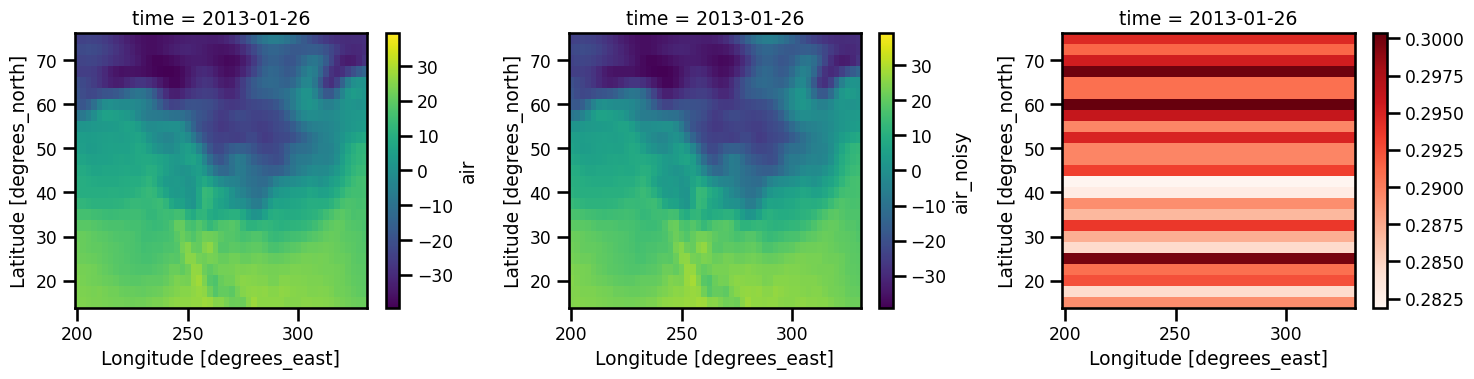

In [88]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 100

ds.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
ds.air_noisy.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
np.abs(ds.air.isel(time=itime) - ds.air_noisy.isel(time=itime)).unstack().plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

In [326]:
# change units
data = ds.air - 273.15

# tranpose
data = data.transpose("time", "lon", "lat")

# create sample dimensions
data = data.stack(spatial=["lon", "lat"])
data = data.transpose("spatial", "time")
n_space = data.spatial.shape[0]
n_time = data.time.shape[0]

In [395]:
n_components = 1 # 1_000

clf = PCA(n_components=n_components, random_state=42)

In [396]:
clf.fit(X=data.values)

X_red = clf.transform(data.values)
X_recon = clf.inverse_transform(X_red)

In [397]:
X_recon.shape, X_red.shape

((1325, 2920), (1325, 1))

In [398]:
out = data.to_dataset()
out["recon"] = (("spatial", "time"), np.real(X_recon))
out = out.unstack()

In [399]:
out.recon.min(), out.recon.max()

(<xarray.DataArray 'recon' ()>
 array(-47.47676086),
 <xarray.DataArray 'recon' ()>
 array(31.77927017))

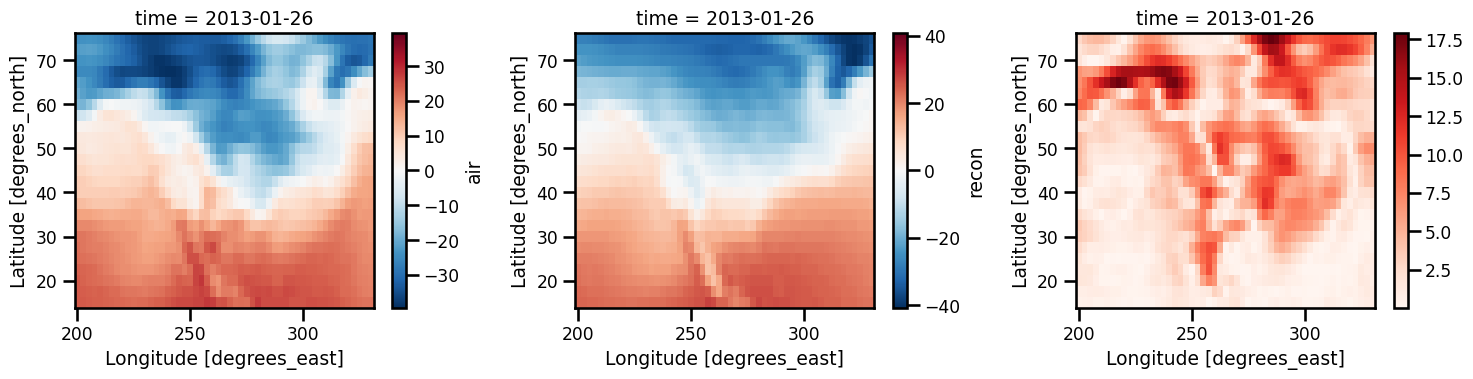

In [400]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 100

out.air.isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
out.recon.isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(out.air - out.recon).isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

## Missing Data

In [402]:
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## SVD

In [339]:
from sklearn.utils.extmath import randomized_svd, _randomized_eigsh

In [359]:
# change units
data = ds.air - 273.15

# tranpose
data = data.transpose("time", "lon", "lat")

# create sample dimensions
data = data.stack(spatial=["lon", "lat"])
data = data.transpose("spatial", "time")
n_space = data.spatial.shape[0]
n_time = data.time.shape[0]

In [360]:
# mean wrt time
data_mean = data.mean(dim=["time"])

# normalized data
data_norm = data - data_mean

# calculate covariance
data_cov = np.cov(data_norm.values, rowvar=False)
assert data_cov.shape == (n_time, n_time)

In [361]:
U, S, VT = randomized_svd(data_norm.values, n_components=n_components, random_state=42)

In [362]:
U.shape, S.shape, VT.shape

((1325, 1), (1,), (1, 2920))

In [363]:
X_recon = U @ np.diag(S) @ VT
X_recon = einx.add("Ns Nt, Ns -> Ns Nt", X_recon, data_mean.values)

In [364]:
out = data.to_dataset()
out["recon_svd"] = (("spatial", "time"), X_recon)
out = out.unstack()

In [365]:
out.recon_svd.min(), out.recon_svd.max()

(<xarray.DataArray 'recon_svd' ()>
 array(-40.29093933),
 <xarray.DataArray 'recon_svd' ()>
 array(33.78026962))

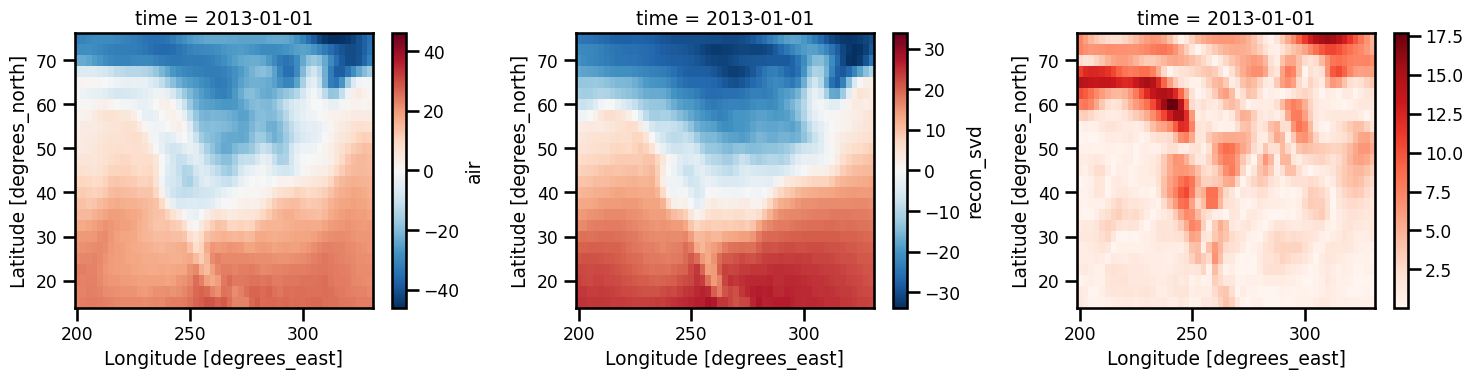

In [366]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

out.air.isel(time=0).plot.pcolormesh(x="lon", ax=ax[0])
out.recon_svd.isel(time=0).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(out.air - out.recon_svd).isel(time=0).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

In [216]:
n_time = ds.time.shape[0]


# change units
data = ds.air - 273.15

# tranpose
data = data.transpose("time", "lon", "lat")

# create sample dimensions
data = data.stack(spatial=["lon", "lat"])
data = data.transpose("spatial", "time")
n_space = data.spatial.shape[0]

# mean wrt time
data_mean = data.mean(dim=["time"])

# normalized data
data_norm = data - data_mean
data_norm = data_norm.transpose("spatial", "time")

# calculate covariance
data_cov = np.cov(data_norm.values, rowvar=False)
assert data_cov.shape == (n_time, n_time)

# calculate eigenvalues
lam, phi = np.linalg.eig(data_cov, )
idx = np.argsort(lam)[::-1]
lam = lam[idx]
phi = phi[:, idx]

# calculate time coefficient
A = data_norm.values @ np.real(phi)

# reconstructin


In [218]:
data_cov.shape

(2920, 2920)

In [217]:
A.shape, phi.shape

((1325, 2920), (2920, 2920))

In [139]:
num_modes = None

In [148]:
A.shape, phi.shape

((1325, 2920), (2920, 2920))

In [149]:
data_norm_approx = np.einsum("ij,kj->ik",A[:, :num_modes],phi[:,:num_modes])

In [150]:
data_norm_approx.shape

(1325, 2920)

In [151]:
out = data.to_dataset()
out["modes"] = (("spatial", "time"), np.real(data_norm_approx))
out += data_mean
out = out.unstack()

In [152]:
out

<xarray.Dataset>
Dimensions:  (lon: 53, lat: 25, time: 2920)
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lon, lat) float32 -44.72 -39.77 -31.53 ... 44.21 45.33 46.7
    modes    (time, lon, lat) float64 -32.21 -29.61 -23.41 ... 21.56 22.06 22.56

In [153]:
data_mean.shape, out.modes.shape

((1325,), (2920, 53, 25))

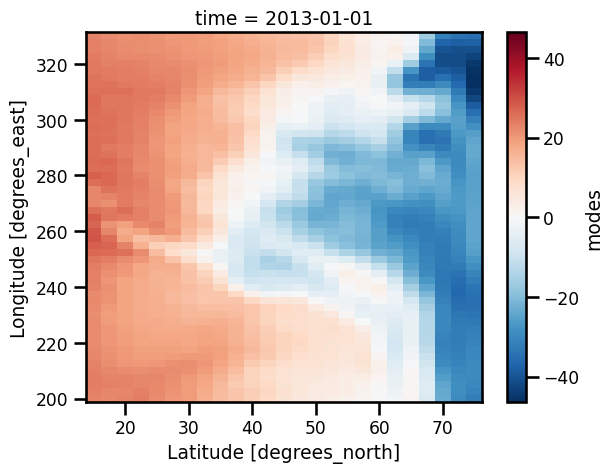

In [154]:
out.modes.isel(time=0).plot.pcolormesh()

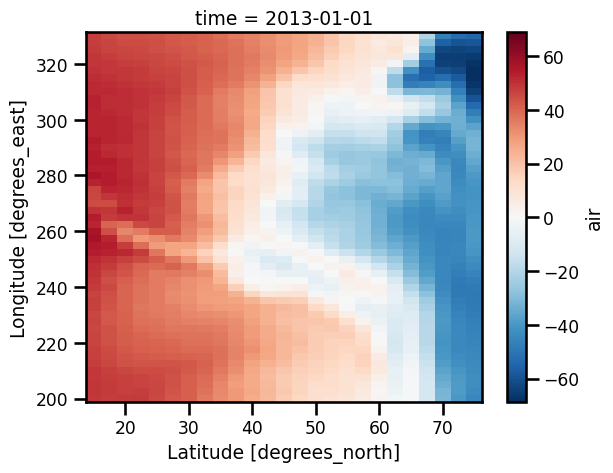

In [155]:
out.air.isel(time=0).plot.pcolormesh()

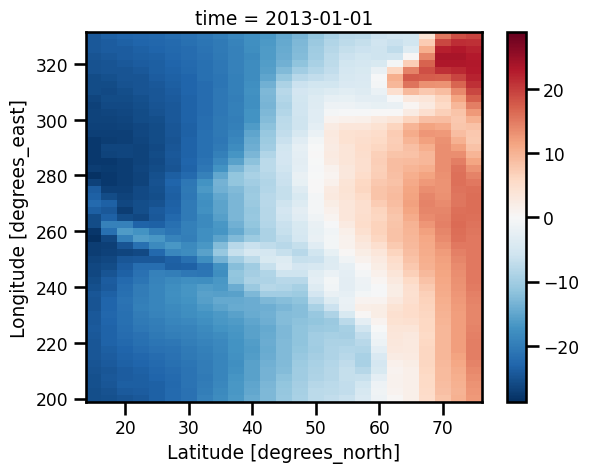

In [147]:
(out.modes - out.air).isel(time=0).plot.pcolormesh()

In [48]:
data_norm_approx.shape

(1325, 2920)

In [27]:
phi.shape, lam.shape

((1325,), (1325, 1325))

In [16]:
data_cov = np.cov(data_norm.values)
data_cov.shape

(1325, 1325)

In [9]:
data_cov = xr.cov(data_norm, data_norm, dim="time", )

In [10]:
data_cov.shape

(1325,)